# Project: Wrangle and Analyze Data

## Introduction

Real-world data rarely comes clean. Using Python and its libraries, I will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. I will document my wrangling efforts in a Jupyter Notebook using Python (and its libraries).

The dataset that I will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. WeRateDogs has over 4 million followers and has received international media coverage.

I am gona use numerous python libraries and also for better review of data I also use notepad++ and excel. 

My goal: Wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. 

In [684]:
import pandas as pd
import numpy as np
import tweepy as tp
import requests, json, os, timeit, re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

## Part 1: Gathering Data
I have three different sources and three different accesses for data. 
> 1. *The WeRateDogs Twitter archive.* I have to download data from <a href="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv"> twitter_archive_enhanced.csv</a>. After downloading I can use pandas library to load data.
2. *The tweet image predictions.* Now I have to gather data and download them programmatically using the Requests library. Link where you access data <a href="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv">image-predictions.tsv</a>
3. *Twitter API.* Last gathering is little bit complicated. I will need twitter acount. After that I can query data with Twitter API and store data to tweet_json.txt.

1. The WeRateDogs Twitter archive

In [685]:
t_archive = pd.read_csv('twitter-archive-enhanced.csv')
t_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


2. The tweet image predictions.

In [686]:
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
open ('image_predictions.tsv', 'wb').write(r.content)

335079

In [687]:
dog_imgs = pd.read_csv('image_predictions.tsv', '\t')
dog_imgs.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


3. Twitter API

In [16]:
consumer_key = 'xxxxxxxxxxxxxxxxxxxxxxxxx'
consumer_secret = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
access_token = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
access_secret = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [18]:
auth = tp.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tp.API(auth, parser=tp.parsers.JSONParser())

In [19]:
tweeter_archive = t_archive.tweet_id.values
tweeter_api_full = []
done = []
failed = []
for tw_id in tweeter_archive:
    try:
        tweet = api.get_status(tw_id, tweet_mode='extended', wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
        tweeter_api_full.append(tweet)
        done.append(tw_id)
    except:
        failed.append(tw_id)

Rate limit reached. Sleeping for: 611
Rate limit reached. Sleeping for: 609


In [21]:
with open('tweet_json.txt', mode = 'w') as f:
    json.dump(tweeter_api_full, f)

In [44]:
len(done), len(failed)

(2331, 25)

In [688]:
tweet_json_df = pd.read_json('tweet_json.txt')

In [689]:
tweet_json_df.head(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


## Part 2: Assessing Data

#### Tidiness: issues with structure that prevent easy analysis. Untidy data is also known as messy data.

**t_archive**
- timestamp in format YYYY-MM-DD HH:MI:SS +0000, zeros are uselles

**tweet_json_df**
> - created_at in format YYYY-MM-DD HH:MI:SS +0000, zeros are uselles

**t_archive, dog_imgs, tweet_json_df**
> - join data from 3 tables to 1

#### Quality: issues with content. Low quality data is also known as dirty data.
**t_archive**
> - some columns have null values and are incomplete (in_reply_to_status_id, in_reply_to_user_id, expanded_urls)
- 745 without name, 55 with name 'a'
- tweet id is unique and withou duplicity but expanded_urls is duplicated and has different tweet_id
- rating_numerator is from 0 to 1776
- rating_denominator has max value 170
- source with html symbols "href="
- duplicate values - retweeted status
- tweet_id is a integer but it is not actualy number. Should be string
- timestamp is object should be data

**dog_imgs**
> - p1, p2, p3 are breeds of dogs where they have different capitalization (lower case and upper cas) 
- p1, p2, p3 names with underscore instead of space
- jpg_url are duplicated with different tweet_id
- tweet_id is a integer but it is not actualy number. Should be string

**tweet_json_df**
> - columns have many missing values
- source with html symbols "href="
- duplicate values - retweeted status

In [690]:
t_archive.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
927,754856583969079297,NaN,NaN,2016-07-18 01:53:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Winnie. She's not a fan of the fast mo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754856583...,11,10,Winnie,None,None,None,None
1200,716730379797970944,NaN,NaN,2016-04-03 20:53:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",There has clearly been a mistake. Pup did noth...,NaN,NaN,NaN,https://twitter.com/chpsanfrancisco/status/716...,12,10,None,None,None,None,None
961,751132876104687617,NaN,NaN,2016-07-07 19:16:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He's just so damn happy. 10/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751132876...,10,10,Cooper,None,None,None,puppo


In [691]:
t_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [692]:
t_archive[t_archive['tweet_id'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [693]:
t_archive[t_archive['text'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [694]:
t_archive[t_archive['expanded_urls'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
75,878281511006478336,NaN,NaN,2017-06-23 16:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Shadow. In an attempt to reach maximum zo...,NaN,NaN,NaN,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
76,878057613040115712,NaN,NaN,2017-06-23 01:10:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Emmy. She was adopted today. Massive r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
98,873213775632977920,NaN,NaN,2017-06-09 16:22:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sierra. She's one precious pupper. Abs...,NaN,NaN,NaN,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,667182792070062081,NaN,NaN,2015-11-19 03:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Timison. He just told an awful joke bu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667182792...,10,10,Timison,None,None,None,None
2293,667152164079423490,NaN,NaN,2015-11-19 01:27:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pipsy. He is a fluffball. Enjoys trave...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None
2294,667138269671505920,NaN,NaN,2015-11-19 00:32:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Extremely intelligent dog here. Has learned to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
2298,667070482143944705,6.670655e+17,4.196984e+09,2015-11-18 20:02:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After much debate this dog is being upgraded t...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None


In [695]:
t_archive.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
          ... 
Bloo         1
Mya          1
Glenn        1
Roscoe       1
Mitch        1
Name: name, Length: 957, dtype: int64

In [696]:
t_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [697]:
dog_imgs.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1400,768609597686943744,https://pbs.twimg.com/media/CqqmWa7WcAAIM-n.jpg,1,basenji,0.183283,True,Italian_greyhound,0.136012,True,whippet,0.060130,True
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False


In [698]:
dog_imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [699]:
dog_imgs.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [700]:
dog_imgs[dog_imgs['jpg_url'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True


In [701]:
dog_imgs[dog_imgs['jpg_url'] == 'https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
591,679158373988876288,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.25153,True,bath_towel,0.116806,False
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.25153,True,bath_towel,0.116806,False


In [702]:
tweet_json_df.sample(3)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
2008,2015-12-01 17:37:36+00:00,671744970634719232,671744970634719232,Very fit horned dog here. Looks powerful. Not ...,False,"[0, 136]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 671744965807087616, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2055,2015-11-29 04:37:03+00:00,670823764196741120,670823764196741120,This is Remington. He's a man dime. 12/10 http...,False,"[0, 65]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 670823755950768128, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2150,2015-11-24 18:01:05+00:00,669214165781868544,669214165781868544,This is Jaspers. He is a northeastern Gillette...,False,"[0, 134]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 669214160572411904, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [703]:
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   id                             2331 non-null   int64              
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [704]:
tweet_json_df.describe()

,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,geo,coordinates,contributors,retweet_count,favorite_count,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str
count,2.331000e+03,2.331000e+03,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,0.0,0.0,0.0,2331.000000,2331.000000,2196.0,2196.0,2.600000e+01,2.600000e+01
mean,7.419079e+17,7.419079e+17,7.440692e+17,7.440692e+17,2.040329e+16,2.040329e+16,NaN,NaN,NaN,2714.788074,7590.491205,0.0,0.0,8.113972e+17,8.113972e+17
std,6.823170e+16,6.823170e+16,7.524295e+16,7.524295e+16,1.260797e+17,1.260797e+17,NaN,NaN,NaN,4591.770898,11778.019426,0.0,0.0,6.295843e+16,6.295843e+16
min,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,NaN,NaN,NaN,1.000000,0.000000,0.0,0.0,6.721083e+17,6.721083e+17
25%,6.782670e+17,6.782670e+17,6.757073e+17,6.757073e+17,3.589728e+08,3.589728e+08,NaN,NaN,NaN,548.500000,1324.000000,0.0,0.0,7.761338e+17,7.761338e+17
50%,7.182469e+17,7.182469e+17,7.032559e+17,7.032559e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,1274.000000,3303.000000,0.0,0.0,8.281173e+17,8.281173e+17
75%,7.986692e+17,7.986692e+17,8.233264e+17,8.233264e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,3152.000000,9297.000000,0.0,0.0,8.637581e+17,8.637581e+17
max,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,NaN,NaN,NaN,78159.000000,156861.000000,0.0,0.0,8.860534e+17,8.860534e+17


In [705]:
tweet_json_df[tweet_json_df['id'].duplicated()]

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status


# Part 3: Cleaning Data

In [734]:
clean_t_archive = t_archive.copy()
clean_dog_imgs = dog_imgs.copy()
clean_tweet_json_df = tweet_json_df.copy()

*Define*
1. Quality - remove retweeted values from clean_t_archive

*Code*

In [735]:
clean_t_archive.drop(clean_t_archive[clean_t_archive['retweeted_status_id'].notnull()== True].index, inplace= True)

*Test*

In [736]:
clean_t_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

*Define*
2. Quality - drop uselles columns

*Code*

In [737]:
clean_t_archive.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp'], axis= 1 , inplace= True)

*Test*

In [738]:
clean_t_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2175 non-null   int64 
 6   rating_denominator  2175 non-null   int64 
 7   name                2175 non-null   object
 8   doggo               2175 non-null   object
 9   floofer             2175 non-null   object
 10  pupper              2175 non-null   object
 11  puppo               2175 non-null   object
dtypes: int64(3), object(9)
memory usage: 220.9+ KB


*Define*
<br>1. Tidiness - remove zeros from timestamp</br>
<br>3. Quality - change timestamp from string to datetime</br>

*Code*

In [739]:
clean_t_archive['timestamp'] = (clean_t_archive.timestamp.str[:-6])

In [740]:
clean_t_archive['timestamp'] = pd.to_datetime(clean_t_archive['timestamp'])

Test

In [741]:
clean_t_archive.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [742]:
clean_t_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2175 non-null   int64         
 1   timestamp           2175 non-null   datetime64[ns]
 2   source              2175 non-null   object        
 3   text                2175 non-null   object        
 4   expanded_urls       2117 non-null   object        
 5   rating_numerator    2175 non-null   int64         
 6   rating_denominator  2175 non-null   int64         
 7   name                2175 non-null   object        
 8   doggo               2175 non-null   object        
 9   floofer             2175 non-null   object        
 10  pupper              2175 non-null   object        
 11  puppo               2175 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 220.9+ KB


*Define*
4. Quality - Change tweet_id, id format from number to string

*Code*

In [743]:
clean_t_archive['tweet_id'] = clean_t_archive['tweet_id'].astype('str')
clean_dog_imgs['tweet_id'] = clean_dog_imgs['tweet_id'].astype('str')
clean_tweet_json_df['id'] = clean_tweet_json_df['id'].astype('str')

*Test*

In [744]:
type(clean_t_archive['tweet_id'].iloc[0]), type(dog_imgs['tweet_id'].iloc[0]), type(clean_tweet_json_df['id'].iloc[0])

(str, str, str)

*Define*
5. Quality - change first letter in dog_imgs table, all will be lower case

*Code*

In [745]:
dog_imgs.p1 = dog_imgs.p1.str.lower()
dog_imgs.p2 = dog_imgs.p2.str.lower()
dog_imgs.p3 = dog_imgs.p3.str.lower()

*Test*

In [746]:
dog_imgs.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
594,679503373272485890,https://pbs.twimg.com/media/CW4UtmYWsAAEjqA.jpg,1,porcupine,0.999846,False,meerkat,0.000072,False,echidna,0.000044,False
2013,879376492567855104,https://pbs.twimg.com/media/DDQsQGFV0AAw6u9.jpg,1,tricycle,0.663601,False,labrador_retriever,0.033496,True,pembroke,0.018827,True
223,670303360680108032,https://pbs.twimg.com/media/CU1lWFaVAAAl0HG.jpg,1,shetland_sheepdog,0.380278,True,cardigan,0.342806,True,guinea_pig,0.156249,False


*Define*
6. Quality - remove retweeted values from clean_tweet_json_df

In [747]:
clean_tweet_json_df.drop(clean_tweet_json_df[clean_tweet_json_df['retweeted_status'].notnull()== True].index, inplace= True)

In [748]:
clean_tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2168 non-null   datetime64[ns, UTC]
 1   id                             2168 non-null   object             
 2   id_str                         2168 non-null   int64              
 3   full_text                      2168 non-null   object             
 4   truncated                      2168 non-null   bool               
 5   display_text_range             2168 non-null   object             
 6   entities                       2168 non-null   object             
 7   extended_entities              1987 non-null   object             
 8   source                         2168 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

*Define*
7. Quality - replace dog name from 'a' to none

*Code*

In [749]:
clean_t_archive.name.replace('a', 'None', inplace = True)

*Test*

In [750]:
clean_t_archive['name'].value_counts()

None       735
Charlie     11
Lucy        11
Cooper      10
Oliver      10
          ... 
Marq         1
Jarod        1
Nico         1
Taz          1
Mitch        1
Name: name, Length: 955, dtype: int64

*Define*
8. Quality - change name in clean_tweet_json datafrom from id to tweet_id

*Code*

In [751]:
clean_tweet_json_df.rename({'id': 'tweet_id'}, axis=1, inplace=True)

*Test*

In [752]:
clean_tweet_json_df.head(1)

,created_at,tweet_id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


*Define*
2. Tidiness - from 5 columns (name, doggo, floofer, pupper, puppo) make 2 columns(name, type)

*Code*

In [753]:
clean_t_archive.doggo.replace('None', '', inplace= True)
clean_t_archive.floofer.replace('None', '', inplace= True)
clean_t_archive.pupper.replace('None', '', inplace= True)
clean_t_archive.puppo.replace('None', '', inplace= True)

In [754]:
clean_t_archive['type']=clean_t_archive['doggo'] + clean_t_archive['floofer'] + clean_t_archive['pupper'] + clean_t_archive['puppo']

In [755]:
clean_t_archive = clean_t_archive.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

*Test*

In [756]:
clean_t_archive.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,type
884,760190180481531904,2016-08-01 19:07:17,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sadie. She's addicted to balloons. It's t...,https://twitter.com/dog_rates/status/760190180...,10,10,Sadie,
1438,696900204696625153,2016-02-09 03:35:31,"<a href=""http://twitter.com/download/iphone"" r...",This is Rosie. She's a Benebark Cumberpatch. S...,https://twitter.com/dog_rates/status/696900204...,12,10,Rosie,
1341,704847917308362754,2016-03-02 01:56:53,"<a href=""http://twitter.com/download/iphone"" r...","""Yes hi could I get a number 4 with no pickles...",https://twitter.com/dog_rates/status/704847917...,12,10,None,


*Define*
3. Tidiness - merge columns to one and remove columns

*Code*

In [757]:
df_final = pd.merge(clean_t_archive, clean_dog_imgs, on ='tweet_id', how= 'inner' )
df_final = pd.merge(df_final, clean_tweet_json_df, on = 'tweet_id', how = 'inner' )

In [758]:
df_final = df_final.drop(['in_reply_to_status_id','in_reply_to_user_id','in_reply_to_status_id_str','in_reply_to_screen_name','geo','coordinates','place','contributors','retweeted_status','in_reply_to_user_id_str','quoted_status_id','quoted_status_id_str','quoted_status_permalink','quoted_status'], axis=1)

*Test*

In [759]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       1987 non-null   object             
 1   timestamp                      1987 non-null   datetime64[ns]     
 2   source_x                       1987 non-null   object             
 3   text                           1987 non-null   object             
 4   expanded_urls                  1987 non-null   object             
 5   rating_numerator               1987 non-null   int64              
 6   rating_denominator             1987 non-null   int64              
 7   name                           1987 non-null   object             
 8   type                           1987 non-null   object             
 9   jpg_url                        1987 non-null   object             
 10  img_num                 

# Part 4: Storing, Analyzing, and Visualizing Data

In [628]:
df_final.to_csv('twitter_archive_master.csv', index= False, encoding='utf-8')

***Number of retweets over time***

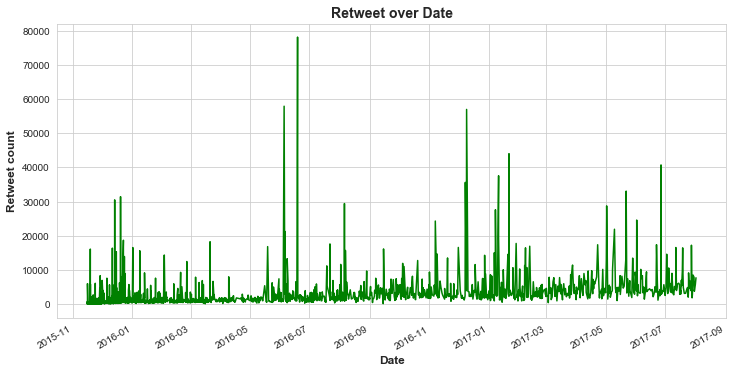

In [760]:
fig, ax = plt.subplots(figsize=(12, 6))
df_final.groupby('timestamp')['retweet_count'].mean().plot(kind='line', color='green')
plt.title('Retweet over Date', weight='bold', size=14)
plt.xlabel('Date',labelpad=5, weight='bold', size=12)
plt.ylabel('Retweet count',labelpad=5, weight='bold', size=12)
plt.show;

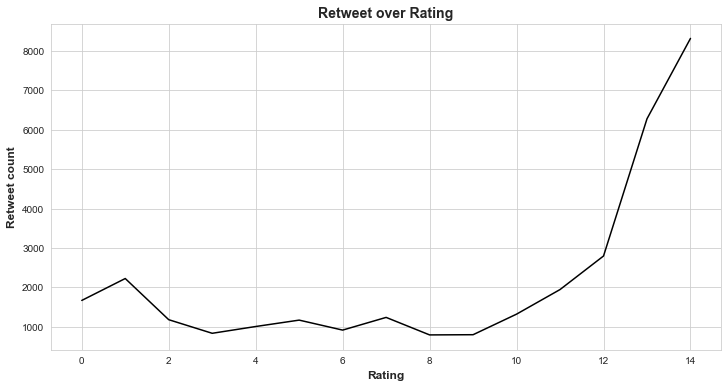

In [761]:
fig, ax = plt.subplots(figsize=(12, 6))
df_final.groupby(df_final[df_final['rating_numerator']<20]['rating_numerator'])['retweet_count'].mean().plot(kind='line', color='black')
plt.title('Retweet over Rating', weight='bold', size=14)
plt.xlabel('Rating',labelpad=5, weight='bold', size=12)
plt.ylabel('Retweet count',labelpad=5, weight='bold', size=12)
plt.show;

***Top ten names and their count of retweets***

In [762]:
df_final.groupby('name').mean().retweet_count.nlargest(10).to_frame()

,retweet_count
name,
Stephan,56995.0
Duddles,40749.0
Jamesy,33090.0
Hurley,18712.0
Aja,17411.0
Lilly,16965.0
Darrel,16571.0
Canela,16481.0
Pipsy,16126.0


***Top ten names ordered by popularity***

In [763]:
df_final.groupby('name').mean().favorite_count.nlargest(10).to_frame()

,favorite_count
name,
Stephan,121155.0
Jamesy,116821.0
Duddles,99611.0
Aja,74800.0
Lilly,67523.0
Canela,64709.0
Pipsy,45731.0
Barney,44360.0
such,43645.0


# Resources 
> - https://knowledge.udacity.com/questions/123023
- https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id
- https://stackoverflow.com/questions/60036847/unicodedecodeerror-charmap-codec-cant-decode-byte-0x83-in-position-7458-cha
- https://stackoverflow.com/questions/39173992/drop-all-data-in-a-pandas-dataframe
- http://docs.tweepy.org/en/v3.2.0/api.html#API
- https://pypi.org/project/requests/
- https://stackoverflow.com/questions/4130027/python-count-elements-in-list
- https://regexone.com/lesson/character_ranges
- https://classroom.udacity.com/
- https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html
- https://mode.com/example-gallery/python_histogram/
